Do not forget to setup GPU accelerator in `Runtime -> Change runtime type -> Hardware accelerator : GPU`

In [1]:
! nvidia-smi
! lscpu
! pip install tensorboardX
! pip install loguru

Thu Feb  6 10:41:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Define model & hyperparameters

In [0]:
import tqdm
import time
from loguru import logger
import pprint

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lrs
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets.cifar import CIFAR10

from torchvision.models.mobilenet import mobilenet_v2
from torchvision.models.resnet import resnet18
from torchvision.transforms import Compose, ToTensor, RandomCrop, RandomHorizontalFlip, Pad, Normalize, ColorJitter, Resize

torch.__version__, torchvision.__version__ 

from tensorboardX import SummaryWriter
from datetime import datetime

import random
import numpy as np

In [0]:
import math

class RandomErasingPIL(object):
    '''
    Class that performs Random Erasing in Random Erasing Data Augmentation by Zhong et al.
    -------------------------------------------------------------------------------------
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing value
    -------------------------------------------------------------------------------------
    '''

    def __init__(self, probability=1, sl=0.05, sh=0.20, r1=1):
        self.probability = probability
        self.sl = sl
        self.sh = sh
        self.r1 = r1

    def __call__(self, img):

        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.size[0] * img.size[1]

            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1 / self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size[1] and h < img.size[0]:
                img_return = img.copy()
                pixels = img_return.load()
                x1 = random.randint(0, img.size[0] - h)
                y1 = random.randint(0, img.size[1] - w)

                if img_return.mode == "L" or img_return.mode == "I" :
                    for i in range(x1, x1 + h):  # for every col:
                        for j in range(y1, y1 + w):  # For every row
                            pixels[i, j] = (0)
                else :
                    for i in range(x1, x1 + h):  # for every col:
                        for j in range(y1, y1 + w):  # For every row
                            pixels[i, j] = (0, 0, 0)
                return img_return

        return img


In [0]:
import random

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset


class ConstantTargetDataset(Dataset):
    """
    Dataset returning a given target for all or only the choosen indexes of the given dataset
    """

    def __init__(self, dataset, target=False, idx_filter=[]):
        self.dataset = dataset
        self.target = target
        self.counter = 0
        self.idx_filter = idx_filter

    def __getitem__(self, item):
        tile, target = self.dataset[item]
        if item in self.idx_filter:
            return tile, self.target
        else:
            return tile, target

    def __len__(self):
        return len(self.dataset)


class AreaUnderTheMarginRanking():
    """
    Implementation of the paper Identifying Mislabeled Data using the Area Under the Margin Ranking: https://arxiv.org/pdf/2001.10528v2.pdf

    Currently the used dataset must not shuffle between epochs !
    """

    # TODO try to use matrix operations
    # TODO manage the case of dataset with shuffling between epochs

    def __init__(self):
        # hist_delta_AUM_current_epoch dimensions: [n_sample, 2 (from in_logit & max(out_logits))]
        self.hist_delta_AUM_current_epoch = torch.zeros(size=(0, 2))
        # hist_delta_AUM dimensions: [n_epoch, n_sample, in_logit & max(out_logits)]
        self.hist_delta_AUM = torch.zeros(size=(0, 0, 2))
        self.reference_sample_idx = []

    def accumulate(self, batch_logits, batch_ids, batch_targets):
        """ To be called after batch prediction"""
        for img_logit, img_id, img_target in zip(batch_logits.split([1] * len(batch_logits), dim=0),
                                                 batch_ids.split([1] * len(batch_logits), dim=0),
                                                 batch_targets.split([1] * len(batch_logits), dim=0)):
            img_logit = img_logit.squeeze(dim=0)
            target_logit = img_logit[img_target]
            if img_target < len(img_logit) - 1:
                notarget_logits = torch.cat([img_logit[:img_target], img_logit[img_target + 1:]], dim=0)
            else:
                notarget_logits = img_logit[:img_target]
            notarget_logits = notarget_logits.max()
            self.hist_delta_AUM_current_epoch = torch.cat(
                [self.hist_delta_AUM_current_epoch, torch.tensor([[target_logit, notarget_logits]])], dim=0)

    def accumulate_epoch(self):
        """ To be called at the end of each epoch"""
        if len(self.hist_delta_AUM) == 0:
            self.hist_delta_AUM = self.hist_delta_AUM_current_epoch.unsqueeze(dim=0)
        else:
            self.hist_delta_AUM = torch.cat([self.hist_delta_AUM, self.hist_delta_AUM_current_epoch.unsqueeze(dim=0)],
                                            dim=0)
        self.hist_delta_AUM_current_epoch = torch.zeros(size=(0, 2))

    def get_reference_aum_threshold(self, percentile=0.99):
        reference_aum = self.hist_delta_AUM[:, self.reference_sample_idx, :]  # => [n_epoch, n_sample, in_logit & max(
        # out_logits)]
        reference_aum = torch.tensor(reference_aum)
        reference_aum = reference_aum[..., 0] - reference_aum[..., 1]  # => [n_epoch, n_sample]
        reference_aum = reference_aum.mean(dim=0)
        reference_aum, _ = reference_aum.sort(dim=0, descending=False)  # => [n_sample]
        aum_threshold_at_percentile = reference_aum[int(len(reference_aum) * percentile)]
        return aum_threshold_at_percentile

    def add_reference_class_to_ds(self, dataset, n_class, exclusion_idx=None):
        """
        Will modify a given dataset by adding the reference class with only mislabeled data.
        Original targets of the dataset must be [0...n_class-1].
        Currently dataset must not shuffle between epochs !

        :param dataset: Dataset to be modified
        :param n_class: Original number of class in Dataset (original targets must be [0...n_class-1])
        :param exclusion_idx: Do not add these idx in the reference class
        :return: new dataset with the added reference class
        """
        if exclusion_idx is None:
            exclusion_idx = self.reference_sample_idx
        n_reference_sample = int(len(dataset) / (n_class + 1))
        print("select n_reference_sample", n_reference_sample)
        self.reference_sample_idx = random.sample(population=range(len(dataset)), k=n_reference_sample)

        new = []
        for el in self.reference_sample_idx:
            if el in exclusion_idx or el in new:
                done = False
                new_el = el
                while not done:
                    new_el += 1
                    if new_el not in new:
                        if new_el < len(dataset):
                            done = True
                            new.append(el)
                        else:
                            new_el = 0
            else:
                new.append(el)
        assert len(set(new)) == len(new)

        dataset = ConstantTargetDataset(dataset,
                                        target=(n_class - 1) + 1,
                                        idx_filter=self.reference_sample_idx)
        return dataset, self.reference_sample_idx

    def get_mislabeled(self):
        """

        :return: list(mislabel indexes of image in dataset)
        """
        threshold = self.get_reference_aum_threshold()

        # reference_aum = self.hist_delta_AUM[:,self.reference_sample_idx,:]
        # reference_aum = torch.tensor(reference_aum)
        reference_aum = torch.tensor(self.hist_delta_AUM)
        reference_aum = reference_aum[..., 0] - reference_aum[..., 1]
        reference_aum = torch.tensor(reference_aum).mean(dim=0)
        # print("reference_aum.shape",reference_aum.shape)
        mislabeled = (reference_aum < threshold).nonzero().tolist()
        # print("mislabeled",mislabeled)
        mislabeled = [el for el in mislabeled if el not in self.reference_sample_idx]
        # print("mislabeled",mislabeled)
        print("percentage of mislabeled", len(mislabeled) / (len(reference_aum) - len(self.reference_sample_idx)),
              len(mislabeled), len(reference_aum), len(self.reference_sample_idx))
        return mislabeled

    def get_hist(self):
        """
        To be use to visualize the results. After the training or after each epoch
        """
        sample_1 = random.randint(0, self.hist_delta_AUM.shape[1])
        sample_2 = random.randint(0, self.hist_delta_AUM.shape[1])
        sample_3 = random.randint(0, self.hist_delta_AUM.shape[1])
        sample_4 = random.randint(0, self.hist_delta_AUM.shape[1])
        sample_5 = random.randint(0, self.hist_delta_AUM.shape[1])

        sample_1 = self.hist_delta_AUM[:, sample_1, :]
        sample_2 = self.hist_delta_AUM[:, sample_2, :]
        sample_3 = self.hist_delta_AUM[:, sample_3, :]
        sample_4 = self.hist_delta_AUM[:, sample_4, :]
        sample_5 = self.hist_delta_AUM[:, sample_5, :]

        plt.figure()
        plt.subplot(511)
        plt.plot(sample_1)
        plt.subplot(512)
        plt.plot(sample_2)
        plt.subplot(513)
        plt.plot(sample_3)
        plt.subplot(514)
        plt.plot(sample_4)
        plt.subplot(515)
        plt.plot(sample_5)
        plt.show()

In [0]:
import json

# global num_epochs, ds


def train(model, optimizer, criterion, train_loader, device ='cuda', **kwargs):
    """ On one epoch """

    global global_step
    model.train()
    time_spent = 0
    with tqdm.tqdm(total=len(train_loader), leave=False, desc="Iterations") as pbar:
      for idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()    
            x, y = x.to(device), y.to(device)
            loss = None
            
            # torch.cuda.synchronize()
            epoch_start_time = time.perf_counter()

            loss=0
            y_pred = model(x)

            img_id = range(idx,idx+len(x))
            l = []
            for i in img_id:
              l.append(i)
            img_id = torch.tensor(img_id).to(device)
            aum.accumulate(y_pred, img_id, y)

            not_reduced_loss = criterion(y_pred, y)
            loss += not_reduced_loss.mean()
            loss.backward()        

            optimizer.step()
            # torch.cuda.synchronize()
            epoch_end_time = time.perf_counter()
            time_spent += epoch_end_time-epoch_start_time

            if loss is not None:
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
                writer.add_scalar("Train/batch loss", loss.item(), global_step)
            
            pbar.update()
            global_step += 1
    logger.info("Time spent {:.2f}s".format(time_spent))
    aum.accumulate_epoch()
    aum.get_hist()
    print("aum.get_mislabeled() first 10 are:",aum.get_mislabeled()[0:10])
    print("aum.get_reference_aum_threshold()", aum.get_reference_aum_threshold())

    return time_spent
  
def test(model, test_loader, prefix="Test", global_step=None, device='cuda'):
    """ On one epoch """

    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)            
            y_pred = torch.argmax(y_pred, dim=1)
            num_correct += torch.eq(y_pred, y).sum().item()
            num_samples += y.shape[0]
        
        accuracy = num_correct * 1.0 / num_samples
        print(f"{prefix} accuracy: {accuracy}")
        
        writer.add_scalar(f"{prefix}/accuracy", accuracy, global_step)
    return accuracy
    
def init_exp(device='cuda', img_size=32, batch_size=512, lr_policy="ReduceLROnPlateau", keep_ds_frac=1.0):
  """ Init one experiment """

  now = datetime.now()
  global writer
  writer = SummaryWriter(logdir=f"/tmp/tb_logs/{now.strftime('%Y%m%d-%H%M%S')}")
  global global_step
  global_step = 0

  SEED=2019
  random.seed(SEED)
  torch.manual_seed(SEED)
  np.random.seed(SEED)

  global num_epochs, ds
  if ds == 'CIFAR':
    num_workers = 0
    mean_std = ([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]) # CIFAR-10
    num_epochs = 25

    # Setup dataflow
    train_transform = Compose([
        Pad(4),
        RandomCrop(32),
        RandomHorizontalFlip(),
        RandomErasingPIL(),
        Resize(img_size),
        ToTensor(),
        Normalize(*mean_std)
    ])


    test_transform = Compose([Resize(img_size),
                              ToTensor(), 
                              Normalize(*mean_std) ])

    class ShortenCIFAR(CIFAR10):
      def __len__(self):
        return int(len(self.data) * keep_ds_frac)

    train_ds = ShortenCIFAR(root="/tmp/cifar10", train=True, download=True, transform=train_transform)

    global aum, n_classes
    aum = AreaUnderTheMarginRanking()
    train_ds, reference_class_sample_idx = aum.add_reference_class_to_ds(dataset=train_ds, n_class=n_classes)
    n_classes += 1 

    train_loader = DataLoader(train_ds, 
                            batch_size=batch_size, num_workers=num_workers, 
                            pin_memory=False, shuffle=False, drop_last=False)
    
    val_ds = ShortenCIFAR(root="/tmp/cifar10", train=False, download=False, transform=test_transform)
    test_loader = DataLoader(val_ds, 
                          batch_size=batch_size, num_workers=num_workers, 
                          pin_memory=False, shuffle=False, drop_last=False)


  model = resnet18(pretrained=True).to(device)
  model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,bias=False)
  model.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0) # Identity
  model.fc = torch.nn.Linear(512, n_classes)
  model = model.to(device)
  
  lr = 0.01
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
  if lr_policy == 'ReduceLROnPlateau':
    lr_scheduler = lrs.ReduceLROnPlateau(optimizer, mode='max')
  elif lr_policy == 'OneCycleLR' :
    lr_scheduler = lrs.OneCycleLR(optimizer, max_lr=0.1, total_steps=num_epochs, pct_start=6/num_epochs)
  criterion = nn.CrossEntropyLoss(reduction='none').to(device)

  return model, optimizer, lr_scheduler, criterion, train_loader, test_loader


def run_one_exp(n_epochs, img_size, batch_size, lr_policy, keep_ds_frac, device, **kwargs):
  """ Run a grid of experiments """

  results = {}
  # The grid


  # One experiment
  # Init
  print('\n')
  model, optimizer, lr_scheduler, criterion, train_loader, test_loader = init_exp(img_size=img_size, 
                                                                                  batch_size=batch_size, lr_policy=lr_policy, keep_ds_frac=keep_ds_frac,
                                                                                  device=device) 
  # Train
  time_spent = 0
  for i in range(n_epochs):
    time_spent += train(model, optimizer, criterion, train_loader, device=device, **kwargs)
    acc_train = test(model, train_loader, prefix="Train", global_step=0, device=device) 
    acc_test = test(model, test_loader, prefix="Test", global_step=0, device=device) 
    lr_scheduler.step(acc_test)
  aum.get_hist()

  # Save results & display all performances from start
  results['only result'] = "time_spent: {:.2f}s acc_train: {:.2f} acc_test: {:.2f}".format(time_spent, acc_train, acc_test)
  pprint.pprint(results, width=1)

# Benchmarking Accuracy



Files already downloaded and verified
select n_reference_sample 4545


2020-02-06 10:43:32.509 | INFO     | __main__:train:46 - Time spent 25.92s


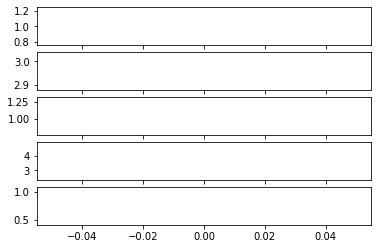

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


percentage of mislabeled 0.6266417335826642 28484 50000 4545
aum.get_mislabeled() [[0], [2], [3], [4], [5], [6], [7], [8], [9], [10]]
aum.get_reference_aum_threshold() tensor(0.3553)
Train accuracy: 0.63174


Iterations:   0%|          | 0/196 [00:00<?, ?it/s]

Test accuracy: 0.7473


2020-02-06 10:45:04.862 | INFO     | __main__:train:46 - Time spent 25.45s


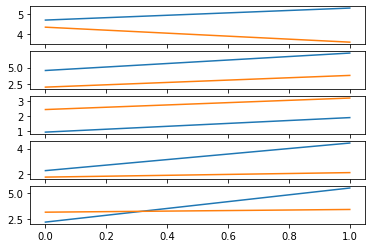

percentage of mislabeled 0.35551644483555167 16160 50000 4545
aum.get_mislabeled() [[2], [9], [13], [15], [17], [19], [25], [27], [29], [35]]
aum.get_reference_aum_threshold() tensor(-0.2157)
Train accuracy: 0.68534


Iterations:   0%|          | 0/196 [00:00<?, ?it/s]

Test accuracy: 0.7751


2020-02-06 10:46:36.103 | INFO     | __main__:train:46 - Time spent 25.47s


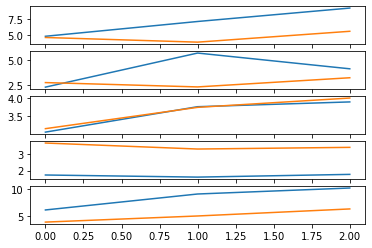

percentage of mislabeled 0.2627213727862721 11942 50000 4545
aum.get_mislabeled() [[9], [13], [17], [19], [22], [25], [27], [35], [38], [39]]
aum.get_reference_aum_threshold() tensor(-0.4070)
Train accuracy: 0.74154


Iterations:   0%|          | 0/196 [00:00<?, ?it/s]

Test accuracy: 0.7929


2020-02-06 10:48:05.282 | INFO     | __main__:train:46 - Time spent 25.07s


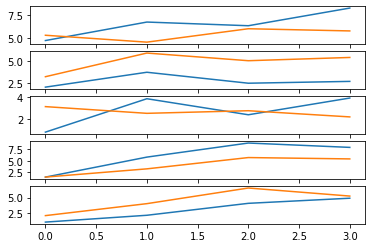

percentage of mislabeled 0.21865581344186558 9939 50000 4545
aum.get_mislabeled() [[9], [17], [25], [35], [39], [46], [47], [50], [51], [56]]
aum.get_reference_aum_threshold() tensor(-0.5059)
Train accuracy: 0.76356


Iterations:   0%|          | 0/196 [00:00<?, ?it/s]

Test accuracy: 0.8221


2020-02-06 10:49:35.231 | INFO     | __main__:train:46 - Time spent 25.14s


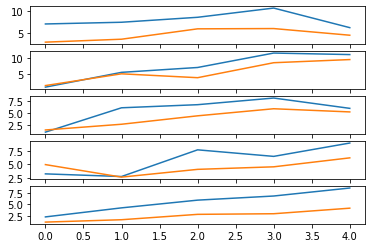

percentage of mislabeled 0.1959960400395996 8909 50000 4545
aum.get_mislabeled() [[9], [17], [25], [35], [39], [46], [47], [51], [56], [64]]
aum.get_reference_aum_threshold() tensor(-0.5456)
Train accuracy: 0.79396


Iterations:   0%|          | 0/196 [00:00<?, ?it/s]

Test accuracy: 0.8532


2020-02-06 10:51:03.920 | INFO     | __main__:train:46 - Time spent 25.07s


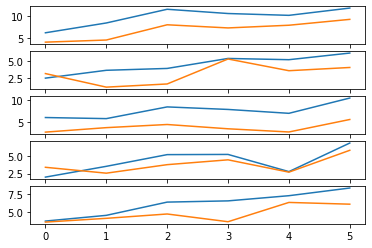

percentage of mislabeled 0.17918820811791883 8145 50000 4545
aum.get_mislabeled() [[9], [17], [25], [35], [39], [46], [47], [51], [56], [64]]
aum.get_reference_aum_threshold() tensor(-0.5961)
Train accuracy: 0.7814


Iterations:   0%|          | 0/196 [00:00<?, ?it/s]

Test accuracy: 0.8218


Iterations:  44%|████▍     | 86/196 [00:25<00:33,  3.26it/s, loss=0.53, lr=0.0103]

In [0]:
# n_steps = 20
n_classes = 10
n_input_ch = 3

img_size = 32 
batch_size = 256

ds = 'CIFAR'
accuracy_test = True

# Exp on CIFAR10
# n Epochs => % of data to remove
# 20E => 26% ?
# 30E => 19%
# 60E => 17% ?
run_one_exp(n_epochs=60, img_size=img_size, batch_size=batch_size, lr_policy="OneCycleLR", keep_ds_frac=1.0, device='cuda')